# 0. Unzip `XPAge01_RGB.zip`

In [71]:
!unzip XPAge01_RGB.zip

Archive:  XPAge01_RGB.zip
replace XPAge01_RGB/XP/JPGs/JPCLN001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: XPAge01_RGB/XP/JPGs/JPCLN001.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN002.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN003.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN004.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN005.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN006.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN007.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN008.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN009.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN010.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN011.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN012.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN013.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN014.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN015.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN016.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN017.jpg  
  inflating: XPAge01_RGB/XP/JPGs/JPCLN018.jpg  
  inflating: XPAge01_RGB/XP/

# 1. Creating `datasets` and 'DataLoader`'s

In [72]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import os
import pandas as pd
from skimage import io

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [74]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
])

In [75]:
class AgeDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, label)

In [76]:
train_data = AgeDataset('./XPAge01_RGB/XP/trainingdata.csv', "XPAge01_RGB/XP/JPGs", transform=data_transform)
test_data = AgeDataset('./XPAge01_RGB/XP/testdata.csv', "XPAge01_RGB/XP/JPGs", transform=data_transform)

len(train_data), len(test_data)

(80, 165)

In [77]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [78]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d22f554c370>,
 <torch.utils.data.dataloader.DataLoader at 0x7d22f51274f0>)

In [79]:
# for img, label in train_dataloader:
#   print(img.shape, label.shape)
#   break

img, label = next(iter(train_dataloader))
print(img.shape, label.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


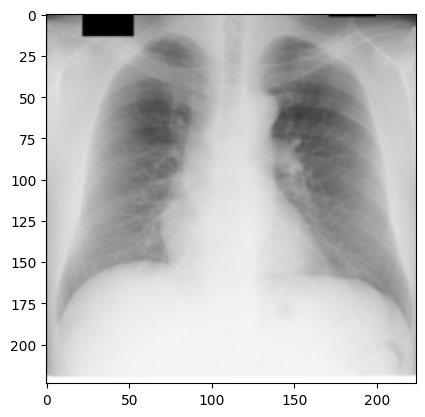

In [80]:
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0));

# 2. Visualizing data

In [81]:
# Take 9 random samples from train data
import random

random_samples = []
random_labels = []

for image, label in random.sample(list(train_data), k=9):
  random_samples.append(image)
  random_labels.append(label)

print(f"Length of Random Samples: {len(random_samples)}\nLenght of Random Labels: {len(random_labels)}")

Length of Random Samples: 9
Lenght of Random Labels: 9


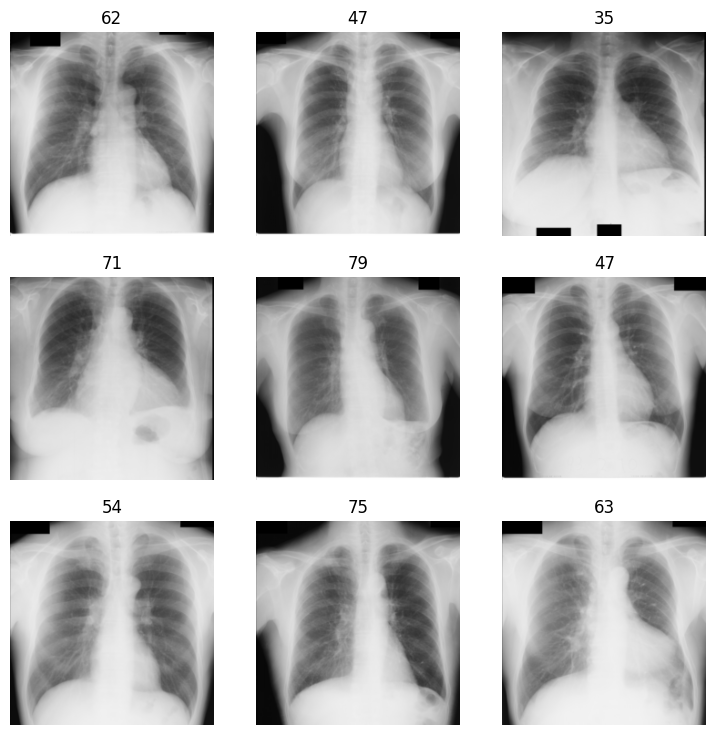

In [82]:
import numpy as np

plt.figure(figsize=(9, 9))
n_rows, n_cols = 3, 3

for i, sample in enumerate(random_samples):
  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(sample.permute(1, 2, 0))
  plt.title(random_labels[i].item())
  plt.axis(False)

# 3. Building a Model

In [83]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, 1)
resnet18 = resnet18.to(device)
resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 4. Setting up `Optimizer` and `Loss Function`

In [84]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(params=resnet18.parameters(),
                       lr = LEARNING_RATE)
loss_fn = nn.L1Loss()

optimizer, loss_fn

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 L1Loss())

# 5. Training and Test step

In [85]:
training_loss, testing_loss = [], []

def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               optimizer:torch.optim.Optimizer,
               loss_fn:torch.nn,
               device:torch.device):
  """Performs a training step"""
  train_loss = 0

  model.to(device)
  model.train()

  for X, y in data_loader:
    X, y = X.to(device), y.to(device)
    y_preds = model(X)

    loss = loss_fn(y_preds.squeeze(), y.squeeze())
    train_loss += loss.item()
    # train_acc += (torch.eq(y_preds, y.squeeze()).sum().item() / len(y_preds)) * 100

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  # train_acc /= len(data_loader)
  training_loss.append(train_loss)
  # training_accuracy.append(train_acc)

  print(f"Training loss: {train_loss:.4f}")

In [86]:
def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn,
              device:torch.device):
  """Performs a testing step"""
  test_loss = 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_test_preds = model(X)

      loss = loss_fn(y_test_preds.squeeze(), y.squeeze())
      test_loss += loss.item()
      # test_acc += (torch.eq(y_test_preds, y.squeeze()).sum().item() / len(y_test_preds)) * 100

    test_loss /= len(data_loader)
    # test_acc /= len(data_loader)
    testing_loss.append(test_loss)
    # testing_accuracy.append(test_acc)

    print(f"Testing loss: {test_loss:.4f}")

In [87]:
from tqdm.auto import tqdm

EPOCHS = 50

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n-------------------")
  train_step(resnet18, train_dataloader, optimizer, loss_fn, device)
  test_step(resnet18, test_dataloader, loss_fn, device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------------------
Training loss: 54.3251
Testing loss: 65.4690
Epoch: 1
-------------------
Training loss: 50.4521
Testing loss: 58.7470
Epoch: 2
-------------------
Training loss: 49.1622
Testing loss: 52.5458
Epoch: 3
-------------------
Training loss: 47.1249
Testing loss: 50.3374
Epoch: 4
-------------------
Training loss: 45.0367
Testing loss: 49.5191
Epoch: 5
-------------------
Training loss: 43.6168
Testing loss: 48.5109
Epoch: 6
-------------------
Training loss: 41.8540
Testing loss: 46.5151
Epoch: 7
-------------------
Training loss: 39.4881
Testing loss: 44.1431
Epoch: 8
-------------------
Training loss: 37.2739
Testing loss: 42.0415
Epoch: 9
-------------------
Training loss: 37.4621
Testing loss: 40.1148
Epoch: 10
-------------------
Training loss: 34.3882
Testing loss: 38.3616
Epoch: 11
-------------------
Training loss: 33.1423
Testing loss: 36.5808
Epoch: 12
-------------------
Training loss: 31.4220
Testing loss: 34.6515
Epoch: 13
-------------------
Train

In [88]:
!nvidia-smi

Sun Mar 10 01:07:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              29W /  70W |   1535MiB / 15360MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 6. Plotting training and testing losses

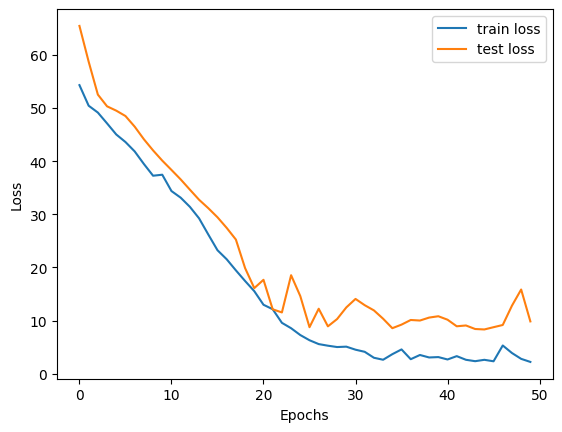

In [89]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(training_loss, label="train loss")
plt.plot(testing_loss, label="test loss")
plt.legend()
plt.show()

# 7. Plotting Predictions

In [90]:
# Take 9 random samples from test data
import random

random_samples = []
random_labels = []

for samples, labels in random.sample(list(test_data), k=9):
  random_samples.append(samples)
  random_labels.append(labels)

len(random_samples), len(random_labels)

(9, 9)

In [91]:
# Function to make predictions on this data list
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  """Makes predictions on data from list"""

  pred_probs = []

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = sample.unsqueeze(dim=0).to(device)
      pred_prob = model(sample)
      pred_probs.append(pred_prob.squeeze().cpu())

  return torch.stack(pred_probs)

In [92]:
pred_probs = make_predictions(model=resnet18,
                 data=random_samples,
                 device=device)
pred_probs[:2]

tensor([61.4140, 49.2828])

In [93]:
random_labels, pred_probs

([tensor(78),
  tensor(50),
  tensor(53),
  tensor(64),
  tensor(75),
  tensor(28),
  tensor(64),
  tensor(62),
  tensor(76)],
 tensor([61.4140, 49.2828, 52.2237, 64.7821, 63.3898, 35.5844, 55.4256, 58.4585,
         67.4007]))

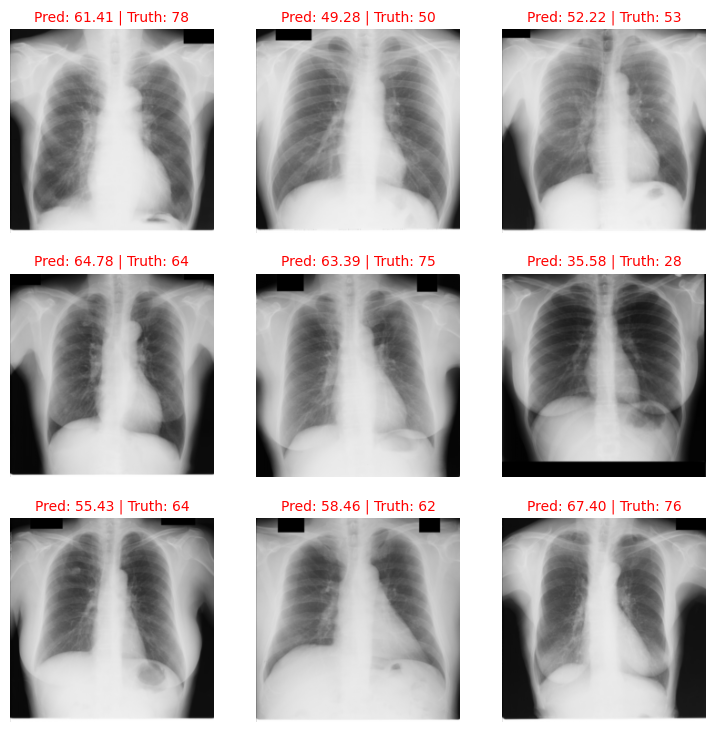

In [94]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(random_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1, 2, 0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = pred_probs[i]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = random_labels[i]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label:.2f} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [97]:
print(f"Lowest MAE Achieved was {min(testing_loss)}")

Lowest MAE Achieved was 8.337843259175619
